<a href="https://www.kaggle.com/code/diaconumadalina/multilabel-image-classification-movie-poster-genre?scriptVersionId=154541934" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

The notebook addresses a multi-label classification problem involving movie genres based on movie posters. 
* It emphasizes using the "macro soft-F1 loss" as a robust evaluation metric, avoiding the need for continuous threshold adjustments in real-world applications. The workflow includes:
     
     1. data collection 
     2. data preparation
     3. fast input pipeline in Tensorflow
     4. build a model 
         * with transfer learning from TensorFlow Hub
     5. training and evaluating the model
     6. Decision threshold 
     7. Evaluate the performance
     8. exporting and saving the TensorFlow models. 

This approach simplifies multi-label classification in production settings, making it practical and efficient.

# 1. Data Collection




In the data collection phase of our project, we will utilize a dataset called 'MovieGenre.csv,' which has been sourced from the Kaggle platform https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster.

 This dataset contains information about various movies, including references to download their respective movie posters and details about the genres associated with each movie. The data in 'MovieGenre.csv' was originally compiled from the IMDb website, and it serves as the foundational dataset for our project.

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

In [ ]:
# pip install --upgrade pip

In [ ]:
!pip install utils

In [ ]:
# importing necessary libraries

import os
# The os module provides a way to interact with the operating system. It includes functions for working with files and directories, executing commands, and more. It's commonly used for tasks such as file manipulation, directory operations, and accessing environment variables.

import zipfile
# The zipfile module provides tools for working with ZIP archives. It allows you to create, read, or write to ZIP files and extract files from ZIP archives.

import pandas as pd # A powerful data manipulation library in Python. It provides data structures like DataFrames for efficient data analysis.
import numpy as np # A fundamental package for scientific computing with Python. It provides support for large, multi-dimensional arrays and matrices.

from utils import *
# Assuming that utils is a custom module, it might contain various utility functions or code that you've defined elsewhere in your project. The specific functionalities within the utils module depend on its implementation in your project.

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
# Matplotlib is a 2D plotting library for creating static, animated, and interactive visualizations in Python. Seaborn is a statistical data visualization library based on Matplotlib, providing a high-level interface for drawing attractive and informative statistical graphics.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import calibration_curve
# Scikit-Learn: A machine learning library that provides simple and efficient tools for data analysis and modeling, including classification, regression, clustering, and more.

import requests
# Requests: A Python library for making HTTP requests. It simplifies the process of sending HTTP requests and receiving responses.

from PIL import Image
# PIL (Python Imaging Library): A library for opening, manipulating, and saving many different image file formats.

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# TensorFlow (tf): An open-source machine learning framework developed by the Google Brain team. It allows for building and training deep learning models.
# TensorFlow Hub (hub): A library to share and discover pre-trained models. It simplifies the process of using pre-trained models in your TensorFlow applications.

from time import time
# Time: A module in Python that provides various time-related functions.

import shutil
# Shutil: A module in Python that provides a higher-level interface for file operations. It simplifies tasks such as copying, moving, and deleting files and directories.

from datetime import datetime
#T he datetime module provides classes for working with dates and times. It includes the datetime class, which is commonly used for representing and manipulating dates and times.

from keras.preprocessing import image
# Keras: A high-level neural networks API written in Python, running on top of TensorFlow. It allows for easy and fast prototyping.


In [ ]:
project_dir = '/kaggle/input/'
os.chdir(project_dir)

# Read dataset

In [ ]:
movies = pd.read_csv('/kaggle/input/movieg-first-work/movies.csv', encoding="ISO-8859-1")
movies.head()

In [ ]:
label_freq = movies['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending = False)
label_freq
# The explode() method converts each element of the specified column(s) into a row.
# movies['Genre'].apply(lambda s: str(s).split('|')).explode()

In [ ]:
# pip install plotly

In [ ]:
import plotly.express as px

# Assuming you have label_freq as a Pandas Series with index as genre names and values as their frequencies.

fig = px.bar(label_freq, x=label_freq, y=label_freq.index, orientation='h', color=label_freq.index)
fig.update_layout(title="Genre Frequency", xaxis_title="", yaxis_title="Genres")
fig.show()

In [ ]:
print("number of movie posters:", len(movies))


# Clean dataset

In [ ]:
# Clean dataset

# remove rows having a missing id, gendre, poster
movies.dropna(subset = ['imdbId', 'Genre', 'Poster'], inplace = True)

# remove "adult" movies
movies.drop(movies[movies['Genre'].str.contains('Adult')].index, inplace = True)

movies.head(5)

In [ ]:
# Save the CSV file to the /kaggle/working/ directory

# movies.to_csv('/kaggle/working/movies.csv', index=False)

In [ ]:
movies = pd.read_csv("/kaggle/input/movieg-first-work/movies.csv")
print("Number of movie posters in movies.csv, first csv: {}\n".format(len(movies)))
movies.head(3)

# Download images

 This script is designed to download movie posters from IMDb using parallel execution for efficiency. It includes error handling and progress tracking. 
 The download_image function is retried in case of failures, and the tqdm library is used to display a progress bar during the downloads. 
 The script stops downloading once the specified limit of successful downloads (SUCCESSFUL_DOWNLOAD_LIMIT) is reached.

In [ ]:
# !pip install tqdm

#  tqdm library, which provides a fast, extensible progress bar for loops and other iterable computations.

In [ ]:
# # parallel processing
# # To make the code run faster, you can leverage parallel processing. One way to achieve this is by using the concurrent.futures module, 
# # which provides a high-level interface for asynchronously executing functions using threads or processes. 


# import os
# import requests
# import pandas as pd
# from retrying import retry
# from tqdm import tqdm
# import concurrent.futures

# # Import Statements:
# # The code starts by importing necessary Python modules and libraries, including os for operating system interactions
# # , requests for making HTTP requests, pandas for data manipulation, retry for retrying failed operations, tqdm for displaying progress bars, and concurrent.futures for parallel execution.

# # SUCCESSFUL_DOWNLOAD_LIMIT = 30000
# # # Constants:
# # #  Defines a constant SUCCESSFUL_DOWNLOAD_LIMIT with a value of 30,000. This sets the maximum number of successful downloads the script aims to achieve.   

# def download_image(url, output_path):
#     @retry(wait_exponential_multiplier=1000, wait_exponential_max=10000, stop_max_attempt_number=5)
#     def _download_image():
#         response = requests.get(url, timeout=(5, 10))
#         response.raise_for_status()
#         with open(output_path, 'wb') as f:
#             f.write(response.content)

#     try:
#         _download_image()
#         return True  # Indicate successful download
#     except Exception as e:
#         return False  # Indicate failed download
# # Defines a function download_image that attempts to download an image from a given URL and save it to a specified output path. It includes retry logic to handle potential network issues.

# def download_parallel(row, destination):
#     imdb_id = row['imdbId']
#     poster_url = row['Poster']

#     if not pd.isna(poster_url):
#         try:
#             file_extension = poster_url.split('.')[-1]
#             filename = f"{imdb_id}.{file_extension}"
#             success = download_image(poster_url, os.path.join(destination, filename))
#             return success, imdb_id
#         except Exception as e:
#             return False, imdb_id
#     return False, None
# # Defines a function download_parallel that takes a row from a DataFrame, extracts the IMDb ID and poster URL, and attempts to download the corresponding image in parallel. It uses the download_image function.

# def main():
#     df = pd.read_csv("/kaggle/working/movies.csv")
#     output_directory = '/kaggle/working/images'
#     os.makedirs(output_directory, exist_ok=True)

#     successful_downloads = 0
#     failed_downloads = 0

#     with tqdm(total=len(df), desc="Downloading") as pbar, \
#             concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = {executor.submit(download_parallel, row, output_directory): row for _, row in df.iterrows()}

#         for future in concurrent.futures.as_completed(futures):
#             success, imdb_id = future.result()
#             if success:
#                 successful_downloads += 1
#             else:
#                 failed_downloads += 1

#             pbar.update(1)

#     print(f"Total successful downloads: {successful_downloads}")
#     print(f"Total failed downloads: {failed_downloads}")
# # Defines the main function main that reads a CSV file containing movie information, creates an output directory for images, and initiates parallel downloads of movie posters using ThreadPoolExecutor. 
# # It also tracks the number of successful and failed downloads.

# if __name__ == "__main__":
#     main()
# # Checks if the script is being executed as the main program, and if so, calls the main function.



In [ ]:
# number of images from /working/images
import os

# Specify the directory path
directory_path = '/kaggle/input/movieg-first-work/images'

# List all files in the directory
files = os.listdir(directory_path)

# Filter only files with certain image extensions (adjust as needed)
image_extensions = ['.jpg']
image_files = [file for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]

# Count the number of image files
num_images = len(image_files)

# Print the result
print(f"Number of images in {directory_path}: {num_images}")


In [ ]:
# The movies' final dataframe, including downloaded posters, will be stored in a CSV file within the "final" directory. This file will serve as a persistent source of data, allowing you to retrieve the movie information without the need to re-download the images in subsequent notebook runs.


# 2. Data preparation

Data preparation is crucial for building effective machine learning models. For instance, if a movie genre is rare, it's wise to exclude it from the target variable. This ensures the model focuses on well-represented genres, enhancing its ability to make accurate predictions.

Analyzing label frequencies involves creating a graph that shows genres ranked by their occurrence. This helps identify prevalent and rare genres in the dataset, offering insights into data distribution.

Define a process to filter your movie dataset based on the IMDb IDs of the downloaded images. This is a good approach to ensure that you have a dataset that corresponds only to the movies for which you have images.

In [ ]:
import os
import pandas as pd

# Define the directory path where the images are stored
image_directory = '/kaggle/input/movieg-first-work/images' #"/kaggle/working/images"

# List the IMDb IDs from the filenames in the directory
downloaded_imdb_ids = [int(os.path.splitext(filename)[0]) for filename in os.listdir(image_directory)]
# downloaded_imdb_ids
# Assuming you have a DataFrame named 'movies' with an 'imdbId' column
# Filter the 'movies' DataFrame to include only rows with IMDb IDs in 'downloaded_imdb_ids'
filtered_movies_dataframe = movies[movies['imdbId'].isin(downloaded_imdb_ids)]
# Remove duplicate rows based on the 'imdbId' column
filtered_movies_dataframe = filtered_movies_dataframe.drop_duplicates(subset='imdbId')

In [ ]:
#save the filtered_movies
# output_path = '/kaggle/working/filtered_movies.csv'
#filtered_movies_dataframe.to_csv(output_path, index=False)

In [ ]:
import pandas as pd

# Replace 'your_path/filtered_movies.csv' with the actual path to your CSV file
csv_file_path = '/kaggle/input/movieg-first-work/filtered_movies.csv' #'/kaggle/working/filtered_movies.csv'

# Read the CSV file into a DataFrame
movies = pd.read_csv(csv_file_path)

# Display the number of rows in the DataFrame
num_rows = len(movies)
print(f"Number of rows in the dataset, after check the first csv with the downloaded images : {num_rows}")

In [ ]:
# Check for duplicates in the 'imdbId' column of filtered_movies_dataframe
duplicates = movies[movies.duplicated('imdbId', keep=False)]

# 'duplicates' will contain the rows with duplicate IMDb IDs
if not duplicates.empty:
    print("Duplicate IMDb IDs found:")
    print(duplicates)
else:
    print("No duplicate IMDb IDs found.")


In [ ]:
movies

In [ ]:
# import pandas as pd

# # Specify the CSV file path
# csv_file_path = '/kaggle/working/movies.csv'

# # Read the CSV file with a different encoding
# movies = pd.read_csv(csv_file_path, encoding='ISO-8859-1')

# # Now 'movies' contains the data from the CSV file


# Label frequency

In [ ]:
label_freq = movies['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending = False)

In [ ]:
# The explode() method converts each element of the specified column(s) into a row.
movies['Genre'].apply(lambda s: str(s).split('|')).explode()

In [ ]:
# plt.figure(figsize=(12,10))
# sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
# plt.title("Genre frequecy", fontsize=14)
# plt.xlabel("")
# plt.show()

In [ ]:
import plotly.express as px

# Assuming you have label_freq as a Pandas Series with index as genre names and values as their frequencies.

fig = px.bar(label_freq, x=label_freq, y=label_freq.index, orientation='h', color=label_freq.index)
fig.update_layout(title="Genre Frequency", xaxis_title="", yaxis_title="Genres")
fig.show()

# Remove infrequent labels

To address rare and difficult-to-predict labels, we'll modify the Genre column by downplaying or concealing these infrequent labels. Essentially, we'll make these labels less important for the model, letting it concentrate on predicting the more common ones effectively.


In [ ]:
# remove rare labels
rare = list(label_freq[label_freq<1500].index)
print("We will be ignoring these rare labels:", rare)

In [ ]:
movies

In [ ]:
# remove the rare list from movies
movies['Genre'] = movies['Genre'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
movies.head()

In [ ]:
movies

# Train / Validation examples

It is a common practice in machine learning to partition the modeling data into two subsets: a training set and a validation set. 

In this notebook, we will allocate 80% of the images for training and 20% for validation. 

While it's typical to reserve a separate test set for evaluating the model's performance, we won't be using it in this specific notebook.


In [ ]:
# Train validation split

X_train, X_val, y_train, y_val = train_test_split(movies['imdbId'], movies['Genre'], test_size=0.2, random_state=45)
print("number of posters for training set", len(X_train))
print("number of posters for validation set", len(X_val))


In [ ]:
X_train

In [ ]:
# fill the names for images path for train and test data

# '/kaggle/input/moviedata/filtered_movies.csv'
# X_train = [os.path.join('/gdrive/MyDrive/movie_poster/downloaded_images', str(f)+'.jpg') for f in X_train]
# X_val = [os.path.join('/gdrive/MyDrive/movie_poster/downloaded_images', str(f)+'.jpg') for f in X_val]
# X_train[:5]

X_train = [os.path.join('/kaggle/input/movieg-first-work/images', str(f)+'.jpg') for f in X_train] #/kaggle/working/images
X_val = [os.path.join('/kaggle/input/movieg-first-work/images', str(f)+'.jpg') for f in X_val] #/kaggle/working/images
X_train[:5]

In [ ]:
# for multi hot encoding - create the targets as a list of strings

y_train = list(y_train)
y_val = list(y_val)
y_train[:5]

In [ ]:
y_val[:5]

# Examples of images

Images from training images:

In [ ]:
# image from dataset

nrobsv = 12
ncols = 4
nrows=nrobsv//ncols #3

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols): #12
  ax=plt.subplot(nrows, ncols, i+1)
  plt.imshow(Image.open(X_train[i]))
  plt.title(y_train[i], size=10)
  plt.axis('off')

# Label encoding



 To facilitate the training of a neural network for multi-label classification, we need to convert our original string-based labels into binary format, specifically using multi-hot encoding. This conversion is crucial to represent multiple labels associated with each data point.

 To achieve this transformation, we will employ scikit-learn's MultiLabelBinarizer.
 
 This tool will take our human-understandable lists of strings, where each string corresponds to a label, and convert them into binary vectors. Each vector will be a binary representation of the presence or absence of a specific label, allowing the neural network to comprehend and learn from the multi-label nature of the data during the training process.


Initializes a MultiLabelBinarizer (mlb) object and fits it to the training labels (y_train). This step is necessary to determine the unique classes in the multi-label problem.
After Retrieves the unique classes (labels) from the MultiLabelBinarizer and iterates over them.

In [ ]:
# Label encoding

# To facilitate the training of a neural network for multi-label classification, we need to convert our original string-based labels into binary format, specifically using multi-hot encoding. This conversion is crucial to represent multiple labels associated with each data point.

# To achieve this transformation, we will employ scikit-learn's MultiLabelBinarizer.
# This tool will take our human-understandable lists of strings, where each string corresponds to a label, and convert them into binary vectors. Each vector will be a binary representation of the presence or absence of a specific label, allowing the neural network to comprehend and learn from the multi-label nature of the data during the training process.

# apply MultiLabelBinarizer on y train set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# loop over all labels and show them

N_LABELS = len(mlb.classes_)
for(i, label) in enumerate(mlb.classes_):
  print("{}. {}".format(i, label))

In [ ]:
mlb

In [ ]:
mlb.classes_

In [ ]:
# y_train

Transforms the original multi-label training and validation sets (y_train and y_val) into binary matrices using the MultiLabelBinarizer. Each row in the resulting matrix corresponds to a sample, and each column corresponds to a label. If a label is present for a sample, the corresponding entry is set to 1; otherwise, it is set to 0.

In [ ]:
# transform the y var for train and test

y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [ ]:
y_train_bin

In [ ]:
# check if it is correct, we should have binary targets instead of list of strings
for i in range(5):
    print(X_train[i], y_train_bin[i])

# 3. Fast input pipeline

A fast input pipeline in the context of machine learning refers to an efficient system for loading and preprocessing data to feed into a machine learning model during the training or inference process. The goal is to minimize the time spent on data loading and preparation so that the model spends more time learning from the data.

Key aspects of a fast input pipeline include:

1. **Parallelization:** Loading and preprocessing data in parallel to take advantage of multi-core processors or GPUs, reducing the overall time required for data preparation.

2. **Batching:** Grouping the data into batches allows for more efficient processing, as operations can be parallelized across batches. It also helps to optimize memory usage.

3. **Prefetching:** Overlapping the data loading and model training so that the next batch is ready for processing as soon as the current batch is completed. This helps to keep the hardware resources (CPU, GPU) busy and can lead to faster training times.

4. **Data Augmentation:** Applying data augmentation techniques within the input pipeline to increase the diversity of the training data. This can improve the model's ability to generalize to new, unseen data.

5. **Optimized File Formats:** Choosing file formats that are optimized for fast reading, such as TFRecord files in TensorFlow or HDF5 files. This can significantly speed up the data loading process.

6. **Shuffling:** Randomizing the order of the data to prevent the model from learning patterns based on the order of the training examples. Shuffling is commonly used during the training phase.

7. **Memory Efficiency:** Optimizing memory usage, especially for large datasets. Techniques such as memory mapping or using generators can be employed to handle datasets that do not fit entirely in memory.

8. **GPU Acceleration:** Offloading data loading operations to the GPU when possible, reducing the communication time between the CPU and GPU.

A fast input pipeline is essential for achieving high training throughput, especially when dealing with large datasets and complex models. Efficient data handling can contribute significantly to the overall performance of a machine learning system.




### Introduction to the Challenge:
If you've worked with Keras's image data iterators like ImageDataGenerator and DirectoryIterator, you've likely appreciated their convenience for traditional multi-class classification. These iterators are designed around a specific directory structure, where each subdirectory represents a distinct class.

### Limitations in Multi-label Classification:
However, when dealing with multi-label classification, this conventional directory structure becomes impractical. In multi-label scenarios, a single image may belong to multiple classes simultaneously, deviating from the one-subdirectory-per-class approach.

### The Need for Custom Approaches:
Traditional iterators may not suit these scenarios. Here's where approaches like the tf.data API come into play. This API provides advantages such as speed, precise control, and seamless integration with TensorFlow.

### Leveraging tf.data for Multi-label Classification:
Instead of relying on a fixed directory structure, custom functions can be implemented. These functions parse and preprocess image data, offering the flexibility required for multi-label classification tasks.

### Key Aspects of the Custom Function:
1. **Image Parsing and Feature Label Generation:**
   The custom function parses image files and generates tensors for features and labels.

2. **Handling Image Resizing and Normalization:**
   This function manages tasks like resizing images to match the model's input expectations and normalizing pixel values to a range between 0 and 1.

3. **Importance of Normalization:**
   Normalizing pixel values is crucial for stabilizing the training process. It ensures that gradients remain within a manageable range, contributing to smoother and more effective model training.

### The Power of tf.data API:
In summary, the tf.data API stands out due to its speed, fine-grained control, and seamless integration with TensorFlow. Customizing functions to parse and preprocess images transforms tf.data into a potent tool for multi-label classification. This customization provides the necessary flexibility when dealing with observations that can belong to multiple classes simultaneously.

In [ ]:
# Image Processing Parameters:

# IMG_SIZE: Specifies the height and width of the image to match the input format of the model.
# CHANNELS: Represents the number of color channels (RGB in this case).
    
IMG_SIZE = 224 
CHANNELS = 3 

In [ ]:
# # Image Parsing Function
# parse_function: Takes a filename and label as input and returns a tuple of normalized image array and labels array.
# The image is read, decoded, resized, and normalized in this function.
# tf.data API

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # read an image from a file
    image_string = tf.io.read_file(filename)
    # decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [ ]:
# Dataset Abstraction:

# BATCH_SIZE: Specifies the size of each batch during training.
# AUTOTUNE: Dynamically adjusts preprocessing and prefetching workload.
# SHUFFLE_BUFFER_SIZE: Controls the size of the buffer used for shuffling the training data.
# tf.data.Dataset abstraction

BATCH_SIZE = 256 # big enough to measure an F1 score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 #shuffle the train data by a chunk of 1024 obsv

AUTOTUNE, in the context of TensorFlow's tf.data API, dynamically adjusts the workload related to preprocessing and prefetching based on the training of the model and the consumption of batches. It is recommended to set the number of elements to prefetch to be at least equal to, or possibly greater than, the number of batches consumed during a single training step.

By using AUTOTUNE, the tf.data runtime is empowered to dynamically fine-tune this value during runtime. This adaptation helps in minimizing idle time for both the GPU and CPU. Essentially, AUTOTUNE optimizes the data pipeline, ensuring that the system remains efficiently utilized during the training process, enhancing overall training performance.

In [ ]:
# Dataset Creation Function:
# create_dataset: Generates training and validation datasets.
# filenames and labels are used to create a dataset, followed by parsing and preprocessing.
# If in training mode, the dataset is cached and shuffled.
# Batching and prefetching are applied for efficiency.

def create_dataset(filenames, labels, is_training = True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    #  create a first data set of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls = AUTOTUNE)
    if is_training == True:
      # this is a small dataset, only load it once, and keep it in memory
      dataset = dataset.cache()
      # shuffle the data each buffer size
      dataset = dataset.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
    # batch the data from multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # fetch batches in the background while the model is training
    dataset = dataset.prefetch(buffer_size = AUTOTUNE)
    return dataset

In [ ]:
# Dataset Creation for Training and Validation:
# train_ds and val_ds are created using the create_dataset function.

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [ ]:
train_ds

Each batch will be a pair of arrays (one that holds the features and another one that holds the labels).
The features arrray will be of shape (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS).
The labels array will be of shape (BATCH_SIZE, N_LABELS) where N_LABELS is the maximum number of labels.

Let's verify the shapes of these arrays by analyzing the first batch:

In [ ]:
# Checking Shapes of Batches:
# Prints the shapes of the features and labels arrays for the first batch.


for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Have a dataset with the following characteristics:

- Features Array Shape: (256, 224, 224, 3)
  - This suggests that you have 256 samples in your batch.
  - Each sample is an image with a shape of (224, 224, 3).
  - The dimensions (224, 224) are likely the height and width of the images, and the dimension 3 represents the color channels (typically Red, Green, and Blue).

- Labels Array Shape: (256, 15)
  - This indicates that you have 256 samples in your batch, and each sample has 15 labels.
  - The labels could represent different classes or categories associated with each image.
  
These shapes are consistent with a batch of data commonly used in deep learning models for image classification. The 3D array for features represents a batch of images, and the 2D array for labels contains the corresponding labels for each image in the batch.

If you have any specific questions or if there's anything else you'd like assistance with, feel free to let me know!

In summary, this code defines parameters, image parsing functions, and a dataset creation function using the tf.data API. It sets up an efficient data pipeline for multi-label image classification with TensorFlow.



Explanation:
1. **Image Parsing Function (`parse_function`):**
   - Reads an image file, decodes it, resizes it to the specified size (`IMG_SIZE`), and normalizes pixel values to the range [0.0, 1.0].

2. **Dataset Creation Function (`create_dataset`):**
   - Takes a list of image paths (`filenames`) and corresponding labels (`labels`) to create a TensorFlow dataset.
   - Applies the `parse_function` to map and preprocess observations in parallel.
   - If in training mode, caches and shuffles the dataset.
   - Batches the data and prefetches batches in the background for efficiency.

3. **Dataset Creation for Training and Validation (`train_ds` and `val_ds`):**
   - Calls the `create_dataset` function with training and validation data.

4. **Checking Shapes of Batches:**
   - Takes the first batch from the training dataset (`train_ds`) and prints the shapes of the features and labels arrays.

In your specific examples:
- Each image is resized to 224x224 pixels and has 3 color channels.
- Batch size is set to 256.
- The training dataset (`train_ds`) is created from `X_train` and `y_train_bin`.
- The validation dataset (`val_ds`) is created from `X_val` and `y_val_bin`.
- The shapes of the features and labels arrays for the first batch are printed.

# 4. Model building ( Transfer Learning )


### Transfer Learning Overview:
- **Purpose:** Instead of building a new model from scratch, transfer learning is utilized. Pre-trained models, originally trained on ImageNet, are repurposed for specific multi-label classification tasks.
- **Approach:** The pre-trained model serves as a feature extractor, capturing general image representations. A new classifier is added and trained from scratch for the specific task, making adaptation efficient.

### TensorFlow Hub and Pre-trained Models:
- **Resource:** TensorFlow Hub offers pre-trained models and tutorials for using them with the tf.keras API.
- **Links to Tutorials:**
  - [Transfer Learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
  - [Transfer Learning with TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning)
- **TensorFlow Hub Features:**
  - Hub allows publishing and reusing pre-made ML components.
  - Facilitates easy retraining of the top layer of a pre-trained model for new datasets.

### Downloading Headless Model (Feature Extractor):
- **Model Choice:** MobileNet V2 with a depth multiplier of 1.0 and input size of 224x224 is chosen as a feature extractor.
- **Feature Extractor URL:** `"https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"`
- **Feature Extractor Layer:** Created using `hub.KerasLayer`, specifying the input shape.
- **Freezing Variables:** Variables in the feature extractor layer are frozen to prevent modification during training.



In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

# The feature extractor accepts images of shape (224, 224, 3) and returns a 1280-length vector for each image.

# We should freeze the variables in the feature extractor layer, so that the training only modifies the new classification layers.
# Usually, it is a good practice when working with datasets that are very small compared to the orginal dataset the feature extractor was trained on.

The MobileNetV2 model used as a feature extractor has a final layer that produces a 1280-dimensional vector for each input image. This specific architecture is designed with efficiency in mind and is part of the MobileNet family of models developed by Google for mobile and edge devices.

The 1280-dimensional vector is the output of the penultimate layer in the MobileNetV2 architecture, which is a global average pooling layer. This layer takes the spatial average of each feature map and produces a fixed-size output for any input. In the case of MobileNetV2, this output is a 1280-dimensional vector.

The rationale behind using a global average pooling layer and obtaining a fixed-size output vector is to ensure that the model is invariant to the spatial dimensions of the input. This allows the model to be more robust to variations in the size and aspect ratio of input images. Additionally, having a fixed-size output makes it easier to use the MobileNetV2 model as a feature extractor in transfer learning scenarios, where the extracted features are fed into a custom classifier for a specific task.

In summary, the 1280-dimensional vector is the result of the global average pooling layer in MobileNetV2 and serves as a compact representation of the features extracted from the input image. This representation is then used for downstream tasks such as classification or regression.

In [ ]:
feature_extractor_layer.trainable = False

# Fine tuning the feature extractor is only recommended if the training dataset is large and very similar to the original ImageNet dataset.

### Model Building:



1. **Model Type:** Sequential - This means that the model is a linear stack of layers, where you can simply add one layer at a time.

2. **Layers:**
   - **Keras Layer:** This layer, named `keras_layer`, is a pre-trained Keras Layer. The `(None, 1280)` indicates that it outputs a vector of size 1280. The layer has 2,257,984 parameters, and it's non-trainable, meaning these parameters are fixed and won't be updated during training.
   
   - **Dense Layer:** This is a fully connected layer (dense). It takes the 1280-dimensional input from the previous layer and outputs a vector of size 15. It has 19,215 parameters and is trainable.

3. **Total Parameters:** The model has a total of 2,277,199 parameters. This includes trainable and non-trainable parameters.

4. **Trainable Parameters:** The number of parameters that will be updated during training. In this case, it's 19,215.

5. **Non-trainable Parameters:** The number of parameters that are fixed and won't be updated during training. In this case, it's 2,257,984.

This architecture suggests we use of a pre-trained base model (probably for image classification) followed by a dense layer for the specific task at hand (output size 15, which might correspond to different genres). The pre-trained base model likely helps in extracting useful features from the input data.

<!-- - **Classifier Head:** A new classification head is attached to the feature extractor layer.
- **Architecture:**
  - Sequential model with the feature extractor layer.
<!--   - Additional Dense layer with 1024 units and ReLU activation.
  - Output Dense layer with `N_LABELS` units and Sigmoid activation for binary classification.
- **Trainable Parameters:** 19K trainable parameters in the dense layers, with 2.2M frozen parameters in MobileNet V2.
- **Summary:** Model summary is printed, displaying layer information.
-->

**Attach a classification head**

In [ ]:
# Attach a classification head

# Encapsulate the feature extractor layer within a tf.keras.Sequential model and extend it by appending additional layers.

# model = tf.keras.Sequential([
#     feature_extractor_layer,
#     layers.Dense(1024, activation = 'relu', name='hidden_layer'),
#     layers.Dense(N_LABELS, activation = 'sigmoid', name='output')
# ])
# model.summary()

# model_bce = tf.keras.Sequential([
#     feature_extractor_layer,
#     layers.Dense(N_LABELS, activation='sigmoid')
# ])

model_bce.summary()

This code defines the architecture of your neural network model using TensorFlow and Keras. Let's break down each component:

1. **feature_extractor_layer**: This is the MobileNet V2 model loaded from TensorFlow Hub, serving as a feature extractor. It processes input images and outputs a fixed-size feature vector.

    Yes, that's correct. The `feature_extractor_layer` in your model processes input images and outputs a fixed-size feature vector. Here's how it works:

    1.1 **Input Images**: You provide input images to the model. These images should have the same dimensions as the expected input size for the MobileNet V2 model (224x224 pixels with 3 color channels - RGB).

    1.2. **Feature Extraction**: The `feature_extractor_layer` (MobileNet V2) processes each input image through its layers. This process involves convolutions, pooling, and other operations that transform the input image into a higher-level representation, capturing important features.

    1.3. **Fixed-Size Feature Vector**: The output of the `feature_extractor_layer` is a fixed-size feature vector. This vector contains information about the content of the input image in a condensed form. The fixed size is determined by the architecture of the MobileNet V2 model. In this case, it's a 1280-dimensional vector.

    1.4. **Passing Features to the Rest of the Model**: This fixed-size feature vector is then passed to the subsequent layers of your model (dense layers in this case). These layers learn to map these features to the specific labels in your multi-label classification task.

In transfer learning, the idea is that the pre-trained MobileNet V2 model has already learned meaningful features from a large dataset (ImageNet in this case). By using it as a feature extractor, you leverage these learned features for your specific task, which can be especially beneficial when you have a limited amount of data for your specific problem. The subsequent layers of your model then adapt these features to make predictions on your multi-label classification task.

<!-- 2. **layers.Dense(1024, activation='relu', name='hidden_layer')**: This is a dense (fully connected) layer with 1024 neurons. The activation function used is Rectified Linear Unit (ReLU), which introduces non-linearity to the model. This layer is often referred to as a hidden layer because it's not part of the input or output layers. -->

3. **layers.Dense(N_LABELS, activation='sigmoid', name='output')**: This is the output layer of the model. It has a number of neurons equal to the `N_LABELS` variable, which represents the number of labels in your multi-label classification task. The activation function used here is the sigmoid function. Since this is a multi-label classification problem, sigmoid activation is commonly used for each output neuron to produce a probability score between 0 and 1 for each label independently.

The sequential model (`tf.keras.Sequential`) is a linear stack of layers. The data flows sequentially from the first layer (feature_extractor_layer) through the hidden layer to the output layer. During training, the weights of all layers are adjusted to minimize the loss function and improve the model's ability to make accurate predictions on your specific multi-label classification task.



<!-- code defines a TensorFlow Keras sequential model for a multi-label classification task using transfer learning with MobileNetV2

```python
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])
```

1. **`feature_extractor_layer`:**
   - This is the MobileNetV2 feature extractor layer obtained from TensorFlow Hub.
   - It processes input images and outputs a fixed-size feature vector.

2. **`layers.Dense(1024, activation='relu', name='hidden_layer')`:**
   - Adds a dense hidden layer with 1024 units (neurons).
   - The activation function used is Rectified Linear Unit (ReLU), which introduces non-linearity to the model.

3. **`layers.Dense(N_LABELS, activation='sigmoid', name='output')`:**
   - Adds the output layer with `N_LABELS` units.
   - The activation function used is the sigmoid function.
   - The sigmoid activation allows for binary classification for each label independently.
   - In multi-label classification, where an example can belong to multiple classes, sigmoid is often used in the output layer.

In summary, the model architecture is as follows:
- **Input:** Images are processed by the MobileNetV2 feature extractor.
- **Intermediate Layer:** A dense hidden layer with 1024 units and ReLU activation.
- **Output Layer:** A dense output layer with `N_LABELS` units and sigmoid activation for binary classification.

The reason for using MobileNetV2 as a feature extractor is transfer learning. MobileNetV2 has been pre-trained on a large dataset (ImageNet) and has learned useful hierarchical features. By using this pre-trained feature extractor, the model can benefit from these learned features and adapt to the specific task of classifying movie genres based on posters.

During training, the weights of the feature extractor layer are frozen, and only the weights of the dense hidden and output layers are updated. This helps in utilizing the pre-trained knowledge for feature extraction while fine-tuning the model for the specific classification task.

The model is then compiled, and it can be trained on a dataset using a suitable optimizer, loss function, and evaluation metric. The sigmoid activation in the output layer allows for predicting multiple labels for each input image. The training process involves adjusting the model's weights to minimize the specified loss function, making it effective for the given multi-label classification problem. -->



In summary, this model architecture leverages transfer learning by using a pre-trained MobileNet V2 model as a feature extractor and adds custom layers on top for adapting to your specific classification problem. The final layer with sigmoid activation provides probability scores for each label independently, enabling multi-label predictions.

### Checks 

Verify the result of running a forward propagation on the first observation of the first batch.
* Normally, we should see a probability score for each genre and that probability scores do not necessarily sum up to 1.
* This is different from using a softmax layer in multi-class classification where the sum of output probability scores is equal to 1.

In [ ]:
# Assuming `train_ds` is a TensorFlow Dataset
for batch in train_ds:
    # Extract the input data from the batch
    input_data = batch[0]  # Adjust this based on your actual data structure

    # Ensure that the input_data has the correct shape (matching the model's input layer)
    # You may need to reshape or preprocess the data accordingly

    # Make predictions
    predictions = model_bce.predict(input_data)

    # Print or process the predictions as needed
    print(predictions[:1])

    # Stop after processing the first batch
    break


How MobileNet V2 model works?

When you use the MobileNet V2 model as a feature extractor in your model, it processes your input images and transforms them into a fixed-size feature vector. This feature vector captures higher-level patterns and information from the images. The MobileNet V2 model, having been pre-trained on the ImageNet dataset, has learned to recognize general visual features.

Here's how the process generally works in your multi-label classification model:

1. **Loading Pre-trained Model**: You load the pre-trained MobileNet V2 model from the specified URL using TensorFlow Hub.

2. **Feature Extraction**: When you pass an image through this MobileNet V2 model (as a `hub.KerasLayer` in your model), it extracts features from the image and outputs a fixed-size feature vector. This vector is a compact representation of the essential information in the image.

3. **Additional Layers**: You append additional layers on top of the MobileNet V2 model to form your complete model. These additional layers can include dense layers that learn to classify the features extracted by MobileNet V2.

4. **Training**: During the training phase, the weights of the new layers you added are updated based on your dataset. The weights of the pre-trained MobileNet V2 layers remain frozen; only the weights of the newly added layers are trained.

5. **Prediction**: In the prediction phase, when you provide new images to your model, it uses the learned features to make predictions for each label. The final layer may use activation functions like sigmoid to output probabilities for each label independently.

In essence, the MobileNet V2 model acts as a powerful feature extractor that enables your model to recognize important patterns in your specific dataset without starting the learning process from scratch. The added layers specialize in classifying these features for your multi-label classification task.

# 5. Model training and evaluation


**Loss Function:**
In the context of training a neural network for multi-label classification, the loss function is like a guide that helps the model adjust its internal parameters (weights) during training. The goal is to minimize this loss.
In this case, we need a loss function that can measure how far off our model's predictions are from the actual labels in the training data. This function must be differentiable, meaning we can calculate its gradient and use it to update the model weights through backpropagation.

**Evaluation Function:**
While the loss function guides the training process, the evaluation function gives us a clear understanding of how well our model is expected to perform in real-world scenarios. In this notebook, the F1-score is chosen as the evaluation metric.
F1-score is a metric that combines two important aspects of a model's performance: precision and recall. Precision is about how many of the predicted positive instances are actually positive, while recall is about how many of the actual positive instances were correctly predicted.
F1-score, being the harmonic mean of precision and recall, provides a balanced measure of a model's ability to make accurate positive predictions while not missing too many positive instances.

The precision and recall values are calculated using the concepts of True Positives (TP), False Positives (FP), and False Negatives (FN) from a confusion matrix.
TP represents correctly predicted positive instances, FP represents instances predicted as positive but are actually negative, and FN represents instances predicted as negative but are actually positive.

So, in summary, the loss function guides the training process by quantifying the model's prediction errors, and the evaluation function (F1-score) gives us a holistic view of the model's performance based on precision and recall, considering the specifics of True Positives,
 False Positives, and False Negatives for each label.



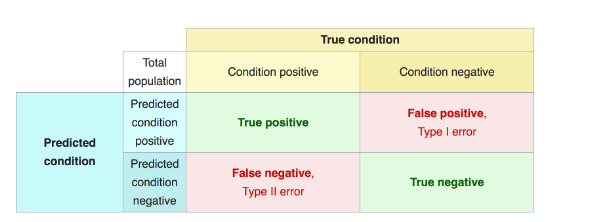

In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)

    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive

    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

# Train

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()
# The tf.keras.backend.clear_session() function is used to clear the global state of the TensorFlow session,
# which includes the model-related states. This can be useful, for example, when you are developing and training 
#multiple models in the same script or notebook and want to release the resources associated with the previous models.

LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

#  LR, which is a small learning rate. Small learning rates are often used in transfer learning scenarios to ensure that the model makes small and gradual updates to the weights, helping to fine-tune the pre-trained model without disrupting the learned features too much.
# EPOCHS: It is set to 30, indicating the number of times the entire dataset will be passed forward and backward through the neural network during training. The number of epochs is a hyperparameter that you can adjust based on your specific problem and dataset. It represents how many times the model will see the entire training dataset.

## Train the model using the binary cross-entropy loss

We will be using the binary cross-entropy loss and metric named macro_f1 is used as one of the evaluation metrics during the training of the model.

### 1. **The macro F1-score ** 

is a metric used for evaluating the performance of a multi-class classification model. It is the harmonic mean of precision and recall, calculated across all classes, and then averaged. The formula for macro F1-score is as follows:

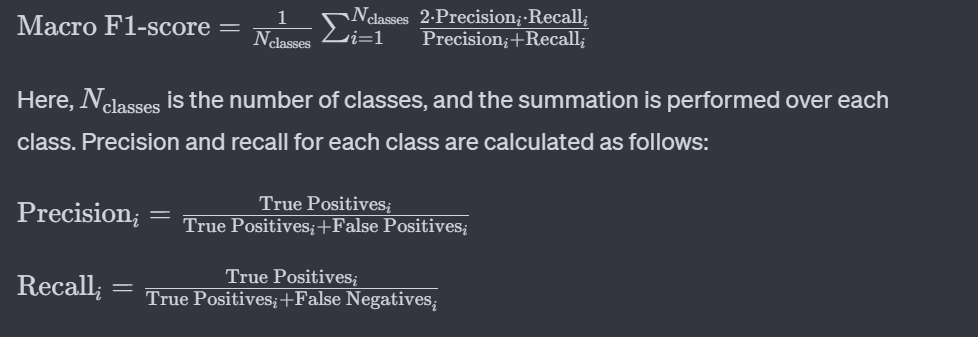


In TensorFlow/Keras, a custom metric function for macro F1-score might look something like this:

```python
import tensorflow as tf

def macro_f1(y_true, y_pred):
    # Assuming y_true and y_pred are one-hot encoded
    true_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 1)), dtype=tf.float32), axis=0)
    false_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 1)), dtype=tf.float32), axis=0)
    false_negatives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 0)), dtype=tf.float32), axis=0)

    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    macro_f1 = tf.reduce_mean(f1)

    return macro_f1
```

This function calculates the macro F1-score for a batch of predictions and true labels. It's important to note that this implementation assumes binary classification for simplicity, and you may need to adapt it for multi-class scenarios. If your problem involves multiple classes, you would need to extend this metric accordingly.

* Model Architecture:

    * model_bce is a Sequential model that consists of a feature extractor layer   (feature_extractor_layer) followed by a dense layer with a sigmoid activation function. This  architecture is commonly used for binary classification problems.

* Compilation:

    * The model is compiled using the Adam optimizer with a specified learning rate (5e-4), binary crossentropy as the loss function (indicating a binary classification task), and a custom metric macro_f1 is added to the list of metrics to monitor during training.

* **macro_f1** metric:

    * It takes y_true (true labels) and y_pred (predicted probabilities) as inputs.
    * It calculates true positives, predicted positives, and actual positives for each class.
    * Precision, recall, and F1-score are calculated for each class.
    * Finally, it takes the mean across all classes to get the macro F1-score.

    This metric is designed for binary classification tasks, and if your problem involves multiple classes, you would need to adapt it accordingly. Also, note that tf.keras.backend.epsilon() is added to avoid division by zero.
    
### 2. **Binary Cross-Entropy Loss**,

often known as Binary Crossentropy, is a commonly used loss function in binary classification tasks. It is suitable for scenarios where each observation can belong to only one of two classes (0 or 1). This loss function quantifies the disparity between the true labels and the predicted probabilities for each observation.

The formula for Binary Cross-Entropy Loss is expressed as follows:

"L(y, ŷ) = - (1/N) * Σ [yᵢ * log(ŷᵢ) + (1 - yᵢ) * log(1 - ŷᵢ)]"

Here:
- N represents the number of observations in the dataset.
- yᵢ denotes the true label for the ith observation (either 0 or 1).
- ŷᵢ is the predicted probability that the ith observation belongs to class 1.

In TensorFlow/Keras, you can utilize `tf.keras.losses.BinaryCrossentropy` to implement Binary Cross-Entropy Loss. Below is an example of how it is typically used in a model:

```python
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[macro_f1]
)
```

In this code snippet:
- `tf.keras.optimizers.Adam` is employed as the optimizer with a specified learning rate.
- `tf.keras.losses.BinaryCrossentropy()` is designated as the loss function, indicating binary classification.
- A custom metric, `macro_f1`, is appended to the list of metrics for monitoring during training.

The objective during training is to minimize this Binary Cross-Entropy Loss, aiming to make the predicted probabilities as close as possible to the true labels. The Adam optimizer is utilized to adjust the model's weights based on the gradients of the loss concerning the weights.

### 3. **tf.keras.optimizers.Adam**:

```python
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
```

`tf.keras.optimizers.Adam` is an instance of the Adam optimizer, which is a popular optimization algorithm used in training neural networks. The Adam optimizer is an extension of the stochastic gradient descent (SGD) algorithm that incorporates adaptive learning rates and momentum.

Here's a breakdown of the components in this line of code:

- `tf.keras.optimizers.Adam`: This is the Adam optimizer class provided by the TensorFlow Keras API. It's an optimization algorithm that adapts the learning rates for each parameter during training.

- `learning_rate=5e-4`: This is a hyperparameter specifying the learning rate for the optimizer. The learning rate controls the step size taken during optimization. A smaller learning rate often leads to slower but more stable convergence, while a larger learning rate may result in faster convergence but with the risk of overshooting the optimal weights.

In summary, the line of code initializes an Adam optimizer with a specified learning rate of `5e-4` (which is equivalent to `0.0005`). This optimizer will be used during the training process to update the weights of the neural network model based on the computed gradients.  

In [ ]:
# model_bce = tf.keras.Sequential([
#     feature_extractor_layer,
#     layers.Dense(N_LABELS, activation='sigmoid')
# ])

# model_bce.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
#     loss=tf.keras.losses.binary_crossentropy,
#     metrics=[macro_f1]
# )

# start = time()
# history_bce = model_bce.fit(train_ds,
#                             epochs=EPOCHS,
#                             validation_data=create_dataset(X_val, y_val_bin))
# training_time = time() - start
# print('\nTraining took {}'.format(training_time))
# # Assuming 'model' is your compiled model
# model_bce.save("/kaggle/working/model_bce")

In [ ]:
# # Assuming 'model' is your compiled model
# model_bce.save("/kaggle/working/model_bce")

In [ ]:
# # Save the training history to a file (e.g., a JSON file)
# import json

# history_path = "/kaggle/working/training_history_bce.json"
# with open(history_path, 'w') as history_file:
#     json.dump(history_bce.history, history_file)
    


In [ ]:
import json
history_path = "/kaggle/input/movieg-first-work/training_history_bce.json"
# Load the training history from the saved file
with open(history_path, 'r') as history_file:
    loaded_history = json.load(history_file)
    

In [ ]:
model_bce.summary()

# How the model works


1. **Image Parsing Function (`parse_function`):**
   - This function takes a filename and a label as input.
   - It reads the image from the file using TensorFlow's `tf.io.read_file` function.
   - The image is then decoded using `tf.image.decode_jpeg` with the specified number of channels (`CHANNELS`).
   - The decoded image is resized to the specified dimensions (`IMG_SIZE`).
   - The image is normalized by dividing pixel values by 255 to bring them into the range [0, 1].
   - The function returns a tuple containing the normalized image array and the labels array.

2. **Dataset Abstraction:**
   - `BATCH_SIZE` is set to 256, which means the model will be trained on batches of 256 images at a time.
   - `AUTOTUNE` is used for dynamic adjustment of preprocessing and prefetching workload.
   - `SHUFFLE_BUFFER_SIZE` is set to 1024, meaning the training dataset will be shuffled in chunks of 1024 observations.

3. **Dataset Creation Function (`create_dataset`):**
   - This function takes a list of filenames, labels, and a boolean indicating whether it's in training mode.
   - It creates a TensorFlow dataset from the filenames and labels.
   - The `parse_function` is applied to each element of the dataset in parallel using `map` with a specified number of parallel calls.
   - If in training mode, the dataset is cached and shuffled.
   - The data is batched into batches of size `BATCH_SIZE`.
   - Prefetching is applied to fetch batches in the background while the model is training.
   - The function returns the final dataset.

4. **Dataset Creation for Training and Validation (`train_ds` and `val_ds`):**
   - These datasets are created using the `create_dataset` function with training and validation data.

5. **Feature Extractor:**
   - The feature extractor is a pre-trained MobileNetV2 model loaded from TensorFlow Hub (`feature_extractor_url`).
   - The `feature_extractor_layer` is a Keras layer created from the URL with the specified input shape.

6. **Freezing Feature Extractor:**
   - The variables in the feature extractor layer are frozen (`feature_extractor_layer.trainable = False`) to prevent them from being modified during training. This is common in transfer learning scenarios.

7. **Model Architecture:**
   - The model is a sequential model.
   - It starts with the frozen feature extractor layer.
   - Followed by a dense layer with the number of units equal to the number of labels (`N_LABELS`), and the activation function is sigmoid.
   - The model is compiled using binary crossentropy as the loss function and Adam optimizer with a small learning rate (`LR`).

8. **Training the Model:**
   - The model is trained using the `fit` method on the training dataset (`train_ds`).
   - The training is performed for a specified number of epochs (`EPOCHS`).
   - Validation data is provided using the validation dataset created with the `create_dataset` function for validation data (`X_val`, `y_val_bin`).

The model learns to predict labels by adjusting the weights of its trainable parameters during training. The training process involves forward and backward passes through the neural network, adjusting the model's parameters to minimize the defined loss function. The training data, consisting of images and corresponding labels, is used for this purpose. After training, the model can be used to predict labels for new images by performing a forward pass through the trained network.

In [ ]:
# # Visualize the learning curves on the training and validation sets when using the macro soft-F1 loss.
history_bce = loaded_history
# After training your model with model.fit(), you can extract the learning curves from the history object
losses = history_bce['loss']
val_losses = history_bce['val_loss']
macro_f1s = history_bce['macro_f1']  # Replace 'macro_f1' with the actual name of your metric
val_macro_f1s = history_bce['val_macro_f1']  # Replace 'val_macro_f1' with the actual name of your validation metric

# Now you have the training and validation curves that you can use for plotting or analysis

import matplotlib.pyplot as plt

# Assuming you have the lists: losses, val_losses, macro_f1s, and val_macro_f1s

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()

# If you have metrics like macro_f1, you can plot them in a similar way
plt.figure(figsize=(12, 6))
plt.plot(macro_f1s, label='Training Macro F1', marker='o')
plt.plot(val_macro_f1s, label='Validation Macro F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Training and Validation Macro F1 over Epochs')
plt.legend()
plt.show()


In [ ]:
history_bce

In [ ]:
# Indicate the performance measured on the validation set.

print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

In [ ]:
train_losses = history_bce['loss']
train_macro_f1s = history_bce['macro_f1']  # Replace 'val_macro_f1' with the actual name of your validation metric

print("Macro soft-F1 loss: %.2f" %train_losses[-1])
print("Macro F1-score: %.2f" %train_macro_f1s[-1])

### Training Set:
- **Macro Soft-F1 Loss:** 0.30
- **Macro F1-Score:** 0.21

### Validation Set:
- **Macro Soft-F1 Loss:** 0.27
- **Macro F1-Score:** 0.24

Here's how you can interpret these results:

1. **Macro Soft-F1 Loss:**
   - The loss on the training set (0.30) is slightly higher than the loss on the validation set (0.27). As mentioned earlier, a small difference in losses is generally acceptable.
   - Lower loss values indicate better performance, so ideally, you would want to minimize this loss.

2. **Macro F1-Score:**
   - The macro F1-score on the training set (0.21) is lower than the macro F1-score on the validation set (0.24).
   - A higher F1-score is generally desired, as it represents a balance between precision and recall. However, the absolute scale of F1-score depends on the nature of the problem, and what is considered "good" can vary.

### Considerations:

- **Overfitting:**
  - The slight difference in performance between the training and validation sets suggests that the model may be overfitting the training data.

- **Model Evaluation:**
  - While F1-score is important, you might also want to consider other metrics, especially if the problem has class imbalances. Precision, recall, and confusion matrices can provide additional insights.

- **Model Complexity:**
  - Evaluate the complexity of the model. If it's too complex, it might be fitting noise in the training data.

- **Hyperparameter Tuning:**
  - Experiment with hyperparameters, such as learning rate or regularization, to see if they impact the model's performance.

- **Data Augmentation:**
  - If not already done, consider applying data augmentation during training to increase the diversity of the training data.

It's an iterative process of experimenting with different aspects and closely monitoring the impact on both training and validation performance. Additionally, you may want to visualize the learning curves over epochs to get a better understanding of how your model is converging.

# 6. Decision threshold


The `utils` module contains a function named `perf_grid` designed to generate a performance grid. Within this grid, thresholds are systematically increased from 0 to 1, with increments of 0.01 applied for each distinct label. 

For every threshold value and each label, a set of performance metrics is calculated. These metrics include true positives (tp), false negatives (fn), false positives (fp), precision, recall, and the F1-score. 

The computation of these metrics is carried out across the range of thresholds, offering a comprehensive evaluation of the model's performance for each label.

**Understanding Thresholds in Multi-Label Classification:**

In multi-label classification, each label has its own decision threshold. The threshold determines the probability above which a label is considered present (1), and below which it is considered absent (0).

**Threshold Evaluation**

Use a validation dataset to evaluate the model's performance with different threshold values.
Iterate over a range of threshold values (e.g., from 0.1 to 0.9) and observe the impact on precision, recall, and the F1 score.

In [ ]:
# # source: https://github.com/ashrefm/multi-label-soft-f1/blob/master/utils.py
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

In [ ]:
# !pip install tensorflow

In [ ]:
import tensorflow as tf


# Load the saved model and provide the custom metric in custom_objects
model_bce = tf.keras.models.load_model("/kaggle/input/movieg-first-work/model_bce", custom_objects={'macro_f1': macro_f1})

# Now 'loaded_model' contains the saved model, and you can use it for predictions or further training.

In [ ]:
# get all label names
label_names = mlb.classes_

#performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

The performance grid when using the second model (optimized with the binary cross-entropy) looks like the following:



In [ ]:
grid_bce.head(15)

For each label, there is a threshold that maximizes the performance of the model trained with the binary cross-entropy loss.
What labels have the highest maximum performance when using the model with bce loss?

In [ ]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

Is there any correlation between the frequency of a label in the dataset and the performance achieved on it?



In [ ]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))

Now, let's compare the performance curves of the model on top 5 labels.

Get the index of top 5 labels with best optimal F1 scores.

In [ ]:
top5 = max_perf.head(7)['id']

Plot the performance curves of precision, recall, F1-score as a function of the threshold.



**Precision-Recall Curve:**

Plot a precision-recall curve for each genre. This curve visualizes the trade-off between precision and recall at different threshold values.
Identify the point on the curve that best balances precision and recall for each genre.

In [ ]:
style.use("default")
for l in top5:
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\n BCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    
    plt.tight_layout()
    plt.show()

# Threshold Selection

**F1 Score Optimization:**

Choose threshold values that maximize the F1 score for each genre. The F1 score is a harmonic mean of precision and recall and provides a balanced measure.

## Choosing the optimal threshold for multi-label classification

Choosing the optimal threshold for multi-label classification where recall equals precision means selecting a threshold for each label in such a way that the precision and recall are balanced. In binary classification, precision is the number of true positives divided by the sum of true positives and false positives, while recall is the number of true positives divided by the sum of true positives and false negatives.

In a multi-label classification scenario, you may have multiple labels, and for each label, you want to find a threshold that results in equal precision and recall. This could be desirable if you want a balance between minimizing false positives and false negatives.

Here's a breakdown of the terms:

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives (TP / (TP + FP)).
- **Recall (Sensitivity):** The ratio of correctly predicted positive observations to the all observations in the actual class (TP / (TP + FN)).

Choosing a threshold where recall equals precision indicates a point on the precision-recall curve where the trade-off between precision and recall is balanced. It means you are setting a threshold such that the number of false positives and false negatives is balanced for each label.

This approach can be useful in scenarios where both false positives and false negatives have significant consequences, and you want to find a compromise between the two. It's a way to fine-tune the decision threshold to meet specific requirements based on the application or domain.

equal_precision_recall_index finds the index where precision equals recall. If such a point exists, it uses the corresponding threshold. If not, it defaults to the threshold of 0.5. This ensures that the threshold is set where precision equals recall for each label.

In [ ]:
num_classes = 15

from sklearn.metrics import precision_recall_curve, f1_score

def find_optimal_thresholds(y_true, y_pred_probs):
    thresholds = np.arange(0.1, 1.0, 0.1)
    optimal_thresholds = {}

    for label in range(num_classes):  # num_classes is the total number of genres
        precision, recall, current_thresholds = precision_recall_curve(y_true[:, label], y_pred_probs[:, label])
        
        # Find the threshold where precision equals recall
        equal_precision_recall_index = np.argmax(precision == recall)
        
        # If there is no point where precision equals recall, use the default threshold (0.5)
        if equal_precision_recall_index:
            optimal_threshold = current_thresholds[equal_precision_recall_index]
        else:
            optimal_threshold = 0.5
        
        optimal_thresholds[label] = optimal_threshold

    return optimal_thresholds


### Implementing Thresholds in Prediction:
Once you have the optimal thresholds, you can apply them to your model's predictions:


In [ ]:
y_hat_val = model_bce.predict(val_ds)
# Define target matrix
y_val = y_val_bin

optimal_thresholds = find_optimal_thresholds(y_val, y_hat_val)
y_pred_val = (y_hat_val > np.array(list(optimal_thresholds.values()))).astype(int)

In [ ]:
optimal_thresholds

# Probability distribution

Let's understand why the perfomance is so stable and does not rely on the threshold when optimizing directly for F1-score.
It would be interesting to analyze the spread of prabability values that come out of the neural network.

In [ ]:
# Predict on the validation set with both models
y_hat_val_bce = model_bce.predict(val_ds)

Visualize the histogram of label probability values with the model.



In [ ]:
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)


style.use("default")
for l in top5:
        
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()
    

### Interpretation curve precision-recall -Performance curves - and Probability distribution - :

In binary classification models trained with binary cross-entropy loss, the F1-score is influenced by the choice of the threshold. The probability distribution of the model's output exhibits Gaussian properties, with bell-shaped histograms. This indicates that the optimization process captures the original distribution of the data, as exemplified by the centering of the 'Drama' label probability distribution around 0.5, which corresponds to the label's prevalence in the dataset (50%).

However, the classifier for 'Drama' seems weak, as there is considerable overlap in probability values between the two classes. Additionally, the model tends to assign lower probability scores to less frequent labels, such as 'Crime' (covering only 14% of the dataset), suggesting that the model learns from the rarity of these labels to predict lower probabilities.

To optimize the model trained with binary cross-entropy loss, one would typically:

A. Explore different decision thresholds to find the optimal value that maximizes performance on a validation set. The F1-score, being threshold-dependent, can be improved by selecting a threshold that balances precision and recall effectively.

B. Consider fixing the threshold at 0.5 for all labels during inference. However, this might not be the optimal threshold for all classes, especially considering the observed probability distribution characteristics. Therefore, a more nuanced approach involves adjusting thresholds based on the specific requirements and characteristics of each label.

### Continuous Monitoring:
Regularly monitor the performance of your model, and if the data distribution or model characteristics change, consider re-evaluating and adjusting the thresholds.

By carefully selecting thresholds, you can tailor your model's predictions to meet the specific requirements of your application.


# Show predictions

We can try and see what the predictions will look like when using our model on posters of some known movies.
The following function simplifies the process of preparing poster data, generating the prediction from the model and visualizing it.

In [ ]:
def show_prediction_05(title, movies_df, model):
    
    # Get movie info
    imdbId = movies.loc[movies['Title']==title]['imdbId'].iloc[0]
    genre = movies.loc[movies['Title']==title]['Genre'].iloc[0]
    img_path = os.path.join('/kaggle/input/movieg-first-work/images', str(imdbId)+'.jpg') #/kaggle/working/images

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
#     Here, the model's predictions for the image are compared to 0.5. If the predicted probability for a particular class is greater than 0.5, it is considered as a positive prediction (1); otherwise, it is considered as a negative prediction (0).
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.show()

If you want to use a different threshold, you would replace 0.5 with your desired threshold value. Keep in mind that the optimal threshold, especially in a multilabel classification setting, can be determined through techniques like threshold optimization based on precision, recall, F1-score, or other relevant metrics.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import style

def show_prediction_optimal(title, movies_df, model, optimal_thresholds, mlb):
    # Get movie info
    imdbId = movies_df.loc[movies_df['Title'] == title]['imdbId'].iloc[0]
    genre = movies_df.loc[movies_df['Title'] == title]['Genre'].iloc[0]
    img_path = os.path.join('/kaggle/input/movieg-first-work/images', str(imdbId) + '.jpg')  # /kaggle/working/images

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE, CHANNELS))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)

    # Generate prediction using optimal thresholds
    y_pred_prob = model.predict(img)
    binary_predictions = (y_pred_prob >= np.array(list(optimal_thresholds.values()))).astype(int)

    # Convert binary predictions to indices
    predicted_indices = np.where(binary_predictions == 1)[1]

    # Convert indices to original labels
    predicted_labels = mlb.classes_[predicted_indices]

    # Display image with prediction
    style.use('default')
    img = Image.open(img_path)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(predicted_labels)), fontsize=9)
    plt.show()


Loop over some movie titles and show the predicted genre.



In [ ]:
filtred_movies =  pd.read_csv('/kaggle/input/movieg-first-work/movies.csv')


In [ ]:
# Example list of image paths
image_paths = [
    '/kaggle/input/movieg-first-work/images/2649194.jpg', #'/kaggle/working/images/2649194.jpg'
    '/kaggle/input/movieg-first-work/images/1570970.jpg',
    '/kaggle/input/movieg-first-work/images/75722.jpg',
    '/kaggle/input/movieg-first-work/images/456873.jpg'
    
]

# Extract IMDb IDs from image paths
imdb_ids = [int(path.split('/')[-1].split('.')[0]) for path in image_paths]

# Match IMDb IDs with movie dataset
matching_movies = movies[movies['imdbId'].isin(imdb_ids)]

# Display movie names
for _, movie in matching_movies.iterrows():
    print(f"The movie name for IMDb ID {movie['imdbId']} is: {movie['Title']}")

In [ ]:
titles = ["Clash of the Titans (2010)",
          "An Affair of Love (1999)",
          "Dragon Ball: Episode of Bardock (2011)"
          ,
          "L'Amour au temps de la guerre civile (2014)",
          "Paranormal Activity: The Marked Ones (2014)",
          "Chef (2014)",
         "Toy Story (1995)",
         "Jumanji (1995)"
         ]

for title in titles:
    print(f"Showing predictions for {title} with optimal thresholds:")
    show_prediction_optimal(title, movies, model_bce, optimal_thresholds, mlb)
    
    print(f"Showing predictions for {title} with threshold 0.5:")
    show_prediction_05(title, movies, model_bce)


# Predict with validation dataset in two ways: optimal and 0.5 treshlods

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
# Assuming you have already defined IMG_SIZE and CHANNELS

IMG_SIZE = 224 
CHANNELS = 3 

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE, CHANNELS))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    return img

# Function to extract image paths and predict labels using optimal thresholds
def predict_optimal_thresholds(model, img_path, optimal_thresholds):
    img = preprocess_image(img_path)
    y_pred_prob = model.predict(img)
    binary_predictions = (y_pred_prob >= np.array(list(optimal_thresholds.values()))).astype(float)
    return binary_predictions

# Function to extract image paths and predict labels using 0.5 threshold
def predict_05_threshold(model, img_path):
    img = preprocess_image(img_path)
    y_pred_prob = model.predict(img)
    binary_predictions = (y_pred_prob > 0.5).astype(float)
    return binary_predictions

# Assuming you have the paths to your validation images
val_image_paths = X_val  # Replace with the actual paths to your validation images

# Initialize a single progress bar for the entire process
total_images = len(val_image_paths)
progress_bar = tqdm(total=2 * total_images, desc="Predicting labels", unit="image")

# Predict using optimal thresholds
y_pred_optimal = []
for i, img_path in enumerate(val_image_paths):
    binary_predictions = predict_optimal_thresholds(model_bce, img_path, optimal_thresholds)
    y_pred_optimal.append(binary_predictions)
    # Update the progress bar
    progress_bar.update(1)

# Predict using 0.5 threshold
y_pred_05 = []
for i, img_path in enumerate(val_image_paths):
    binary_predictions = predict_05_threshold(model_bce, img_path)
    y_pred_05.append(binary_predictions)
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Convert the predictions to a NumPy array
y_pred_optimal = np.array(y_pred_optimal)
y_pred_05 = np.array(y_pred_05)



In [ ]:
import numpy as np

# Assuming y_pred_optimal and y_pred_05 are NumPy arrays
y_pred_optimal = np.array(y_pred_optimal)
y_pred_05 = np.array(y_pred_05)

# Specify file paths for saving the arrays
save_path_optimal = '/kaggle/working/y_pred_optimal.npy'
save_path_05 = '/kaggle/working/y_pred_05.npy'

# Save the arrays to files 
np.save(save_path_optimal, y_pred_optimal)
np.save(save_path_05, y_pred_05)

print(f'y_pred_optimal saved to {save_path_optimal}')
print(f'y_pred_05 saved to {save_path_05}')


# Check functions for first image

In [ ]:
optimal_thresholds

In [ ]:
IMG_SIZE = 224 
CHANNELS = 3 
val_image_paths = X_val
# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE, CHANNELS))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    return img

# Function to extract image paths and predict labels using optimal thresholds
img = preprocess_image(val_image_paths[1])
y_pred_prob = model_bce.predict(img)
y_pred_prob

In [ ]:
np.array(list(optimal_thresholds.values())).astype(float)

In [ ]:
# Convert predicted probabilities to binary predictions using optimal thresholds
binary_predictions = (y_pred_prob >= np.array(list(optimal_thresholds.values()))).astype(float)
binary_predictions

In [ ]:
y_val_bin[1]

In [ ]:
# Assuming the first image index is 0
index_of_first_image = 1

# Extract the path of the first image
first_image_path = X_val[index_of_first_image]

# Predict labels using optimal thresholds for the first image
predictions_optimal_first_image = predict_optimal_thresholds(model_bce, first_image_path, optimal_thresholds)

# Extract the corresponding true labels for the first image
true_labels_first_image = y_val_bin[index_of_first_image]

# Display the path, predictions, and true labels
print(f"Path of the first image: {first_image_path}")
print(f"Predictions for the first image using optimal thresholds: {predictions_optimal_first_image}")
print(f"True labels for the first image: {true_labels_first_image}")


It looks like you've defined a couple of functions for image preprocessing and making predictions using optimal thresholds. These functions seem suitable for a multi-label image classification task. Here's a breakdown of the functions:

1. **preprocess_image**: This function takes an image path as input, loads the image, resizes it to the specified target size (IMG_SIZE x IMG_SIZE), converts it to a NumPy array, normalizes pixel values to the range [0, 1], and adds an extra dimension to make it suitable for input to a neural network.

2. **predict_optimal_thresholds**: This function takes a pre-trained model, an image path, and optimal thresholds as input. It preprocesses the image using the `preprocess_image` function, then makes predictions using the model. The predictions are then thresholded using the provided optimal thresholds, converting them to binary values (0 or 1).

To use these functions, you would provide the path to an image and call `predict_optimal_thresholds` with your pre-trained model and optimal thresholds. The result will be binary predictions for each label based on the specified thresholds.

If you have any specific questions or if you'd like to see an example of how to use these functions, feel free to ask!

In [ ]:
import numpy as np

# Specify file paths for loading the arrays
load_path_optimal = '/kaggle/working/y_pred_optimal.npy'
load_path_05 = '/kaggle/working/y_pred_05.npy'

# Load the arrays from files
loaded_y_pred_optimal = np.load(load_path_optimal)
loaded_y_pred_05 = np.load(load_path_05)

# Now, you can use the loaded arrays as needed
print(f'Loaded y_pred_optimal shape: {loaded_y_pred_optimal.shape}')
print(f'Loaded y_pred_05 shape: {loaded_y_pred_05.shape}')


# 7. Evaluate the performance

In [ ]:
loaded_y_pred_optimal.shape

In [ ]:
loaded_y_pred_05.shape

In [ ]:
y_val_bin.shape

- for optimal treshlod and for 0.5 treshlod

In [ ]:
loaded_y_pred_optimal

In [ ]:
loaded_y_pred_05

In [ ]:
y_val_bin

### Add a header with label names to loaded_y_pred_optimal and y_val_bin and loaded_y_pred_05

In [ ]:
import pandas as pd
import numpy as np

# Assuming label_names is a list of label names
label_names = [
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller'
]

# Reshape the loaded_y_pred_optimal to 2D
loaded_y_pred_optimal_2d = loaded_y_pred_optimal.reshape(-1, len(label_names))

# Create a DataFrame with label names as columns
df_loaded_y_pred_optimal = pd.DataFrame(loaded_y_pred_optimal_2d, columns=label_names)


# Reshape the loaded_y_pred_05 to 2D
loaded_y_pred_05_2d = loaded_y_pred_05.reshape(-1, len(label_names))

# Create a DataFrame with label names as columns
df_loaded_y_pred_05 = pd.DataFrame(loaded_y_pred_05_2d, columns=label_names)


# Reshape the loaded_y_pred_optimal to 2D
loaded_y_val_bin  = y_val_bin.reshape(-1, len(label_names))

# Create a DataFrame with label names as columns
df_y_val_bin  = pd.DataFrame(loaded_y_val_bin, columns=label_names)


# Display the DataFrame with header
print("Loaded y_pred_optimal with header:")
print(df_loaded_y_pred_optimal)

# Display the DataFrame with header
print("Loaded df_loaded_y_pred_05 with header:")
print(df_loaded_y_pred_05)

# Display the DataFrame with header
print("Loaded df_y_val_bin with header:")
print(df_y_val_bin)



In [ ]:
df_loaded_y_pred_optimal.shape

In [ ]:
df_y_val_bin.shape

In [ ]:
df_loaded_y_pred_05.shape

In [ ]:
y_pred_optimal.sum()

In [ ]:
df_loaded_y_pred_05.sum()

In [ ]:
df_y_val_bin.sum()

# Confusion matrix for each label

* loaded_y_pred_optimal

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_pred_optimal and df_y_val_bin are DataFrames
y_pred_optimal = df_loaded_y_pred_optimal
df_y_val_bin = df_y_val_bin

# Initialize lists to store confusion matrices for each label
confusion_matrices = []

# Iterate over each label
for column in y_pred_optimal.columns:
    # Extract the true labels and predicted labels for the current label
    y_true_label = df_y_val_bin[column]
    y_pred_label = y_pred_optimal[column]

    # Compute the confusion matrix for the current label
    conf_matrix_label = confusion_matrix(y_true_label, y_pred_label)

    # Append the confusion matrix to the list
    confusion_matrices.append(conf_matrix_label)

# Calculate sums for each column
tp_list = [np.sum(conf_matrix_label[1, 1]) for conf_matrix_label in confusion_matrices]
tn_list = [np.sum(conf_matrix_label[0, 0]) for conf_matrix_label in confusion_matrices]
fp_list = [np.sum(conf_matrix_label[0, 1]) for conf_matrix_label in confusion_matrices]
fn_list = [np.sum(conf_matrix_label[1, 0]) for conf_matrix_label in confusion_matrices]

# Calculate the number of rows needed based on the number of labels
num_labels = len(y_pred_optimal.columns)
num_rows = (num_labels + 2) // 3  # Ensure there are at least 3 columns

# Set up subplots with 3 columns
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each label
for i, column in enumerate(y_pred_optimal.columns):
    # Extract the confusion matrix for the current label
    conf_matrix_label = confusion_matrices[i]

    # Create a heatmap for the confusion matrix
    sns.heatmap(conf_matrix_label, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])

    # Customize plot
    axes[i].set_title(f'Confusion Matrix for Label: {column}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Adjust layout
plt.tight_layout()
plt.show()

# Print or use the sums as needed
for i, column in enumerate(y_pred_optimal.columns):
    print(f"Label: {column}")
    print(f"TP: {tp_list[i]}, TN: {tn_list[i]}, FP: {fp_list[i]}, FN: {fn_list[i]}")


* loaded_y_pred_05

In [ ]:
loaded_y_pred_05

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# y_pred_optimal
# Assuming y_pred_05 and df_y_val_bin are DataFrames
y_pred_05 = df_loaded_y_pred_05
df_y_val_bin = df_y_val_bin

# Initialize lists to store confusion matrices for each label
confusion_matrices = []

# Iterate over each label
for column in y_pred_05.columns:
    # Extract the true labels and predicted labels for the current label
    y_true_label = df_y_val_bin[column]
    y_pred_label = y_pred_05[column]

    # Compute the confusion matrix for the current label
    conf_matrix_label = confusion_matrix(y_true_label, y_pred_label)

    # Append the confusion matrix to the list
    confusion_matrices.append(conf_matrix_label)

# Calculate sums for each column
tp_list = [np.sum(conf_matrix_label[1, 1]) for conf_matrix_label in confusion_matrices]
tn_list = [np.sum(conf_matrix_label[0, 0]) for conf_matrix_label in confusion_matrices]
fp_list = [np.sum(conf_matrix_label[0, 1]) for conf_matrix_label in confusion_matrices]
fn_list = [np.sum(conf_matrix_label[1, 0]) for conf_matrix_label in confusion_matrices]

# Calculate the number of rows needed based on the number of labels
num_labels = len(y_pred_05.columns)
num_rows = (num_labels + 2) // 3  # Ensure there are at least 3 columns

# Set up subplots with 3 columns
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 3 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()
# The .flatten() method is then applied to the 2D array, converting it into a 1D array. 
#This means that instead of accessing the subplot axes using two indices (row and column), you can now access them with a single index. 
#This is useful when you want to iterate over all subplots using a single loop.
# Iterate over each label
for i, column in enumerate(y_pred_05.columns):
    # Extract the confusion matrix for the current label
    conf_matrix_label = confusion_matrices[i]

    # Create a heatmap for the confusion matrix
    sns.heatmap(conf_matrix_label, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])

    # Customize plot
    axes[i].set_title(f'Confusion Matrix for Label: {column}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Adjust layout
plt.tight_layout()
plt.show()

# Print or use the sums as needed
for i, column in enumerate(y_pred_05.columns):
    print(f"Label: {column}")
    print(f"TP: {tp_list[i]}, TN: {tn_list[i]}, FP: {fp_list[i]}, FN: {fn_list[i]}")


# Images having at least one genre correctly identified

* loaded_y_pred_optimal

In [ ]:
import pandas as pd

# Assuming y_pred_optimal and df_y_val_bin are DataFrames

# Count variables
total_images = 0
correctly_identified_images = 0

# Iterate through each row
for index, (pred_row, true_row) in enumerate(zip(y_pred_optimal.values, df_y_val_bin.values)):
    # Check if at least one genre is correctly identified
    if any(pred_val == true_val == 1 for pred_val, true_val in zip(pred_row, true_row)):
        correctly_identified_images += 1

    total_images += 1

# Calculate accuracy
accuracy = correctly_identified_images / total_images

print(f"Total number of images: {total_images}")
print(f"Images with at least one correctly identified genre: {correctly_identified_images}")
print(f"Accuracy: {accuracy:.2%}")


In [ ]:
import pandas as pd
from collections import defaultdict

# Assuming y_pred_optimal and df_y_val_bin are DataFrames

# Define the maximum number of correct genres to consider
max_correct_genres = y_pred_optimal.shape[1]

# Initialize a defaultdict to store counts for each number of correctly identified genres
correct_genre_counts = defaultdict(int)

# Initialize counters for total images and images with at least two correctly identified genres
total_images = 0
at_least_two_correct_genres = 0

# Iterate through each row
for index, (pred_row, true_row) in enumerate(zip(y_pred_optimal.values, df_y_val_bin.values)):
    # Count the number of correctly identified genres for the current image
    num_correct_genres = sum(pred_val == true_val == 1 for pred_val, true_val in zip(pred_row, true_row))

    # Increment the count in the dictionary for the corresponding number of correct genres
    correct_genre_counts[num_correct_genres] += 1

    # Check if at least two genres are correctly identified
    if num_correct_genres >= 2:
        at_least_two_correct_genres += 1

    total_images += 1

# Calculate accuracy for each number of correct genres
accuracy_by_num_correct_genres = {num: count / total_images for num, count in correct_genre_counts.items()}

# Calculate accuracy for at least two correct genres
accuracy_at_least_two_correct_genres = at_least_two_correct_genres / total_images

# Print the results
print(f"Total number of images: {total_images}")
print(f"Images with at least two correctly identified genres: {at_least_two_correct_genres}")
print(f"Accuracy for at least two correct genres: {accuracy_at_least_two_correct_genres:.2%}")


In [ ]:
import pandas as pd
from collections import defaultdict

# Assuming y_pred_optimal and df_y_val_bin are DataFrames

# Define the maximum number of correct genres to consider
max_correct_genres = y_pred_optimal.shape[1]

# Initialize a defaultdict to store counts for each number of correctly identified genres
correct_genre_counts = defaultdict(int)

# Initialize counters for total images and images with at least three correctly identified genres
total_images = 0
at_least_three_correct_genres = 0

# Iterate through each row
for index, (pred_row, true_row) in enumerate(zip(y_pred_optimal.values, df_y_val_bin.values)):
    # Count the number of correctly identified genres for the current image
    num_correct_genres = sum(pred_val == true_val == 1 for pred_val, true_val in zip(pred_row, true_row))

    # Increment the count in the dictionary for the corresponding number of correct genres
    correct_genre_counts[num_correct_genres] += 1

    # Check if at least three genres are correctly identified
    if num_correct_genres >= 3:
        at_least_three_correct_genres += 1

    total_images += 1

# Calculate accuracy for each number of correct genres
accuracy_by_num_correct_genres = {num: count / total_images for num, count in correct_genre_counts.items()}

# Calculate accuracy for at least three correct genres
accuracy_at_least_three_correct_genres = at_least_three_correct_genres / total_images

# Print the results
print(f"Total number of images: {total_images}")
print(f"Images with at least three correctly identified genres: {at_least_three_correct_genres}")
print(f"Accuracy for at least three correct genres: {accuracy_at_least_three_correct_genres:.2%}")


In [ ]:
import pandas as pd
from collections import defaultdict

# Assuming y_pred_optimal and df_y_val_bin are DataFrames

# Define the minimum number of correct genres to consider (in this case, four)
min_correct_genres = 4

# Initialize a defaultdict to store counts for each number of correctly identified genres
correct_genre_counts = defaultdict(int)

# Initialize counters for total images and images with at least four correctly identified genres
total_images = 0
at_least_four_correct_genres = 0

# Iterate through each row
for index, (pred_row, true_row) in enumerate(zip(y_pred_optimal.values, df_y_val_bin.values)):
    # Count the number of correctly identified genres for the current image
    num_correct_genres = sum(pred_val == true_val == 1 for pred_val, true_val in zip(pred_row, true_row))

    # Increment the count in the dictionary for the corresponding number of correct genres
    correct_genre_counts[num_correct_genres] += 1

    # Check if at least four genres are correctly identified
    if num_correct_genres >= min_correct_genres:
        at_least_four_correct_genres += 1

    total_images += 1

# Calculate accuracy for each number of correct genres
accuracy_by_num_correct_genres = {num: count / total_images for num, count in correct_genre_counts.items()}

# Calculate accuracy for at least four correct genres
accuracy_at_least_four_correct_genres = at_least_four_correct_genres / total_images

# Print the results
print(f"Total number of images: {total_images}")
print(f"Images with at least four correctly identified genres: {at_least_four_correct_genres}")
print(f"Accuracy for at least four correct genres: {accuracy_at_least_four_correct_genres:.2%}")


* loaded_y_pred_05

In [ ]:
import pandas as pd

# Assuming y_pred_optimal and df_y_val_bin are DataFrames

# Count variables
total_images = 0
correctly_identified_images = 0

# Iterate through each row
for index, (pred_row, true_row) in enumerate(zip(y_pred_05.values, df_y_val_bin.values)):
    # Check if at least one genre is correctly identified
    if any(pred_val == true_val == 1 for pred_val, true_val in zip(pred_row, true_row)):
        correctly_identified_images += 1

    total_images += 1

# Calculate accuracy
accuracy = correctly_identified_images / total_images

print(f"Total number of images: {total_images}")
print(f"Images with at least one correctly identified genre: {correctly_identified_images}")
print(f"Accuracy: {accuracy:.2%}")



I presented the confusion matrix separately for each label, considering both an optimally chosen threshold and a fixed threshold set at 0.5. In both cases, I examined how many images correctly identified at least one genre in the posters. 

The findings from both the confusion matrix and the images with at least one accurately identified genre indicate that the accuracy is maximized when using the optimally chosen threshold.

# 8. Export models

After having trained and evaluated the model, we can export it as a TensorFlow saved model for future use.



In [ ]:
# model_bce.save("/kaggle/working/model_bce")
# model_bce.save("/kaggle/working/model_tf", save_format='tf')

We can later reload a tf.keras model by specifying the path to the export directory containing the .pb file.



In [ ]:
# import tensorflow as tf
# loaded_model = tf.keras.models.load_model("/kaggle/working/model_tf")

In [ ]:
# model_bce.summary()

# Summary



1. **Neural Networks in Multi-label Classification:**
   - Traditional methods use multiple logistic regressions for each label independently. Neural networks, however, excel in handling numerous classification problems simultaneously within one model. Mini-batch learning helps manage memory efficiently during training.

2. **TensorFlow Data API (tf.data):**
   - TensorFlow's tf.data is vital for creating efficient input pipelines. It represents observations as pairs of tensors, including images and labels. This abstraction allows easy parallel processing, shuffling, and batching.

3. **Transfer Learning with TensorFlow Hub:**
   - TensorFlow Hub simplifies transfer learning. You can load pre-trained models, like MobileNet, as feature extractors. During training, only the weights of added classification layers are updated, keeping the pre-trained model frozen.

In essence, this approach combines the power of neural networks, efficient data handling with tf.data, and transfer learning via TensorFlow Hub. The focus on optimizing directly for the macro F1 score simplifies training, especially in multi-label scenarios with numerous labels.



### How the prediction process works?

The process of predicting multiple labels for an image involves using a multi-label classification model. In the provided information, the model architecture includes a dense layer with the number of units equal to the number of labels (N_LABELS), and the activation function is sigmoid.

Here's how the prediction process works:

1. **Feature Extraction:**
   - The image is passed through a pre-trained MobileNetV2 model loaded from TensorFlow Hub, serving as a feature extractor. This layer extracts high-level features from the input image.

2. **Dense Layer with Sigmoid Activation:**
   - The output from the feature extractor is then passed through a dense layer with a sigmoid activation function.
   - The sigmoid activation function outputs values between 0 and 1 for each unit in the layer.
   - In multi-label classification, each unit in the dense layer corresponds to a specific label, and the output value represents the confidence or probability that the image belongs to that label.

3. **Prediction for Multiple Labels:**
   - The output of the sigmoid activation for each unit in the dense layer can be considered as the probability that the corresponding label is present in the image.
   - The model predicts multiple labels by thresholding these probabilities. For example, if the output for a particular label is above a certain threshold (e.g., 0.5), it is considered as predicted.

4. **Training for Multi-Label Classification:**
   - During training, the model is provided with training images and their corresponding labels.
   - The binary crossentropy loss function is used, which is suitable for binary classification problems, and in this case, it's applied independently for each label.
   - The model adjusts its weights to minimize the loss, learning to predict the presence or absence of each label in the training images.

5. **Evaluation:**
   - After training, the model can be evaluated on a separate validation dataset to assess its performance in predicting multiple labels for new, unseen images.

In summary, the model is designed to predict the presence or absence of each label independently, allowing it to handle multi-label classification tasks. The sigmoid activation function and binary crossentropy loss are key components that enable the model to make multiple, independent predictions for each label.

Sources:


* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://github.com/berkayalan/neural-networks-and-deep-learning/blob/master/Transfer_learning_with_MobileNet_v1.ipynb
* https://www.analyticsvidhya.com/blog/2021/07/demystifying-the-difference-between-multi-class-and-multi-label-classification-problem-statements-in-deep-learning/
* https://keras.io/api/applications/mobilenet/
* https://github.com/ashrefm
* https://blog.research.google/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.

Multi Label Model Evaluation

* https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation
* https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea
* https://medium.com/@evertongomede/multi-label-classification-in-python-empowering-machine-learning-with-versatility-9dbae34aacdb
* https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
* https://jmread.github.io/talks/Tutorial-MLC-Porto.pdf
* https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
* https://ploomber.io/blog/threshold/


* https://www.evidentlyai.com/classification-metrics/multi-class-metrics